# 'Modelando' - Carregamento de dados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, auc
)

In [2]:
df_encoded =  pd.read_csv('df_encoded.csv')

In [3]:
# 📌 Verificando o balanceamento da variável TARGET

fraud_cases = df_encoded[df_encoded['TARGET'] == 1]
valid_cases = df_encoded[df_encoded['TARGET'] == 0]

outlier_fraction = len(fraud_cases) / float(len(valid_cases))

print(f'Fração de Outliers: {outlier_fraction:.4f}')
print(f"Casos de Fraude: {len(fraud_cases)}")
print(f"Casos Válidos: {len(valid_cases)}")

Fração de Outliers: 0.0878
Casos de Fraude: 24825
Casos Válidos: 282686


# Criar Conjunto de Treino e Teste

In [4]:
from sklearn.model_selection import train_test_split

# Criando o conjunto de treino e teste
X = df_encoded.drop(columns=["TARGET"])  # Todas as colunas exceto TARGET
y = df_encoded["TARGET"]  # Variável alvo

# Divisão 80% treino, 20% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train Shape: {X_train.shape}, {y_train.shape}")
print(f"Test Shape: {X_test.shape}, {y_test.shape}")

Train Shape: (246008, 84), (246008,)
Test Shape: (61503, 84), (61503,)


# Seleção de Features com Random Forest

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Seleção de Features usando Random Forest
sel = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42))
sel.fit(X_train, y_train)

# Features selecionadas
selected_features = X_train.columns[sel.get_support()].tolist()
print(f"Número de Features Selecionadas: {len(selected_features)}")
print(f"Features Selecionadas: {selected_features}")

# Aplicar a seleção de features nos conjuntos de treino e teste
X_train = X_train[selected_features]
X_test = X_test[selected_features]
print(f"Novas Dimensões - X_train: {X_train.shape}, X_test: {X_test.shape}")


Número de Features Selecionadas: 28
Features Selecionadas: ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_FAMILY_STATUS', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR']
Novas Dimensões - X_train: (246008, 28), X_test: (61503, 28)


# Treinar a Regressão Logística

In [6]:
from sklearn.linear_model import LogisticRegression

# 📌 Treinamento da Regressão Logística
logistic_regressor = LogisticRegression(C=2, max_iter=1000)
logistic_regressor.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=2, max_iter=1000)

# Fazer Previsões

In [7]:
# 📌 Realizando previsões
y_pred = logistic_regressor.predict(X_test)
y_pred_prob = logistic_regressor.predict_proba(X_test)[:, 1]  # Probabilidades para a classe 1


# Avaliação do Modelo

In [8]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

# 📌 Avaliação do modelo
print("\n🔹 Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob))



🔹 Accuracy Score: 0.9195161211648212

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56554
           1       0.00      0.00      0.00      4949

    accuracy                           0.92     61503
   macro avg       0.46      0.50      0.48     61503
weighted avg       0.85      0.92      0.88     61503


🔹 ROC AUC Score: 0.6259113674191897


In [ ]:
print(df_encoded["TARGET"].value_counts(normalize=True))


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


Nota: Temos um problema, o modelo de regressão logística, no meu caso, não está lidando bem para prever a classe de inadimplentes (target = 1). Isso era esperado, uma vez que a classe target está desbalanceada (muito menor que 10%) e o modelo é consideravelmente fraco para lidar com desbalanceamento - favorecendo a classe majoritária.
Poderíamos corrigir isso com o ajuste de classe :

In [9]:
logistic_regressor_balanced = LogisticRegression(C=2, max_iter=1000, class_weight='balanced')
logistic_regressor_balanced.fit(X_train, y_train)

y_pred_balanced = logistic_regressor_balanced.predict(X_test)
y_pred_prob_balanced = logistic_regressor_balanced.predict_proba(X_test)[:, 1]

print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred_balanced))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_balanced))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_balanced))



🔹 Accuracy Score: 0.5893533648765101

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.73     56554
           1       0.11      0.57      0.18      4949

    accuracy                           0.59     61503
   macro avg       0.52      0.58      0.45     61503
weighted avg       0.87      0.59      0.68     61503


🔹 ROC AUC Score: 0.6120064149318987


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ou podemos aplicar as técnicas de over/under sampling (que em reuniões técnincas não foi recomendado a fazer inicialmente)

#### Undersampling

In [10]:
from imblearn.under_sampling import RandomUnderSampler

undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

print("📌 Nova distribuição das classes (Undersampling):")
print(y_train_under.value_counts())

# Treinar modelo com undersampling
logistic_regressor_under = LogisticRegression(C=2, max_iter=1000)
logistic_regressor_under.fit(X_train_under, y_train_under)

y_pred_under = logistic_regressor_under.predict(X_test)
y_pred_prob_under = logistic_regressor_under.predict_proba(X_test)[:, 1]

print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred_under))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_under))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_under))


📌 Nova distribuição das classes (Undersampling):
TARGET
0    19876
1    19876
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Accuracy Score: 0.5911744142562152

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.73     56554
           1       0.11      0.57      0.18      4949

    accuracy                           0.59     61503
   macro avg       0.53      0.58      0.46     61503
weighted avg       0.87      0.59      0.68     61503


🔹 ROC AUC Score: 0.6126250816645733


#### Oversampling

In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("📌 Nova distribuição das classes (Oversampling):")
print(y_train_over.value_counts())

# Treinar modelo com oversampling
logistic_regressor_over = LogisticRegression(C=2, max_iter=1000)
logistic_regressor_over.fit(X_train_over, y_train_over)

y_pred_over = logistic_regressor_over.predict(X_test)
y_pred_prob_over = logistic_regressor_over.predict_proba(X_test)[:, 1]

print("🔹 Accuracy Score:", accuracy_score(y_test, y_pred_over))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_over))
print("\n🔹 ROC AUC Score:", roc_auc_score(y_test, y_pred_prob_over))



📌 Nova distribuição das classes (Oversampling):
TARGET
0    226132
1    226132
Name: count, dtype: int64
🔹 Accuracy Score: 0.5934507259808465

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.60      0.73     56554
           1       0.11      0.57      0.18      4949

    accuracy                           0.59     61503
   macro avg       0.52      0.58      0.46     61503
weighted avg       0.87      0.59      0.69     61503


🔹 ROC AUC Score: 0.6117295233748702


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Gráfico de Comparação

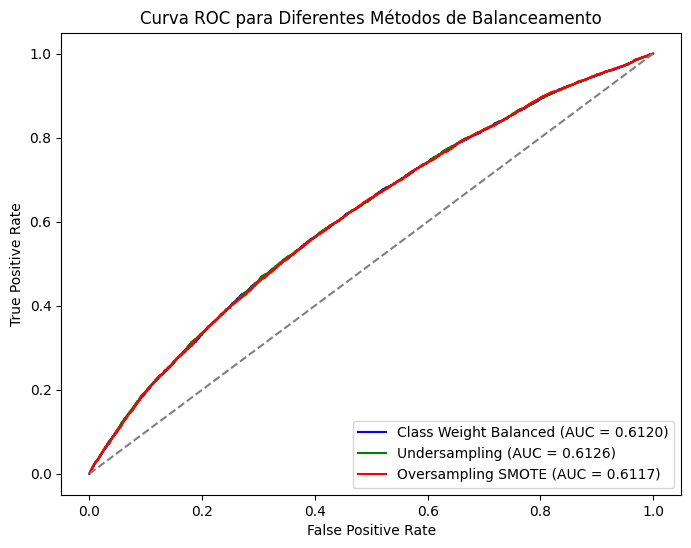

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculando as curvas ROC
fpr_bal, tpr_bal, _ = roc_curve(y_test, y_pred_prob_balanced)
fpr_under, tpr_under, _ = roc_curve(y_test, y_pred_prob_under)
fpr_over, tpr_over, _ = roc_curve(y_test, y_pred_prob_over)

roc_auc_bal = auc(fpr_bal, tpr_bal)
roc_auc_under = auc(fpr_under, tpr_under)
roc_auc_over = auc(fpr_over, tpr_over)

# 📌 Plotando as curvas ROC
plt.figure(figsize=(8,6))
plt.plot(fpr_bal, tpr_bal, label=f"Class Weight Balanced (AUC = {roc_auc_bal:.4f})", color='blue')
plt.plot(fpr_under, tpr_under, label=f"Undersampling (AUC = {roc_auc_under:.4f})", color='green')
plt.plot(fpr_over, tpr_over, label=f"Oversampling SMOTE (AUC = {roc_auc_over:.4f})", color='red')
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Linha base

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC para Diferentes Métodos de Balanceamento")
plt.legend(loc="lower right")
plt.show()


Nota: O modelo melhorou a detecção da classe 1, mas com impacto na acurácia
Sem balanceamento, a classe 1 (inadimplentes) praticamente não era detectada.
Com balanceamento, o recall da classe 1 aumentou bastante (57%), o que significa que o modelo agora está conseguindo identificar mais clientes inadimplentes.
Por outro lado, a acurácia caiu (59%), o que era esperado, pois antes o modelo estava simplesmente classificando quase tudo como 0.
Já que as técnicas de balanceamento tiveram impacto similar, então provavelmente o problema está na capacidade do modelo (Regressão Logística), e não no balanceamento em si.
